# Detección de genomas anómalos de SARS-CoV-2 por medio de algoritmos de aprendizaje no supervisados 

# Reduccion de la dimensionalidad

En esta sección, se implementaron los métodos de reducción de dimensionalidad discutidos en el documento de tesis. Esto con el objetivo de disminuir los 64 atributos que describen a cada genoma en el conjunto de datos a trabajar a solamente 2 atributos. Posteriormente, se crearon visualizaciones del conjunto de datos bajo estas nuevas representaciones y se seleccionan las instancias que presentan el mayor valor de distancia esperada (*distancia euclidiana*) en este nuevo subespacio.

## ➤ Bibliotecas necesarias y configuración inicial

In [1]:
from IPython.display import display
from ipywidgets import widgets, interact
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import euclidean, cityblock, cdist
from scipy.stats import wasserstein_distance, entropy, pearsonr, spearmanr
from scipy.stats.mstats import gmean
from sklearn.decomposition import PCA

Configuración para el estilo a utilizar en las gráficas.

In [2]:
BACK = 'white'
FRONT = (230/255,236/255,245/255)

plt.rc('figure', facecolor=BACK, edgecolor='white')
plt.rc('axes', facecolor=FRONT, edgecolor='white', labelsize=14, labelweight='medium', titlesize=18, grid=True, axisbelow=True)
plt.rc('grid', color='white')

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 11)

---

## ➤ Obtención de los datos a trabajar

Se obtiene el conjunto de datos de todos los genomas secuenciados de SARS-CoV-2, previamente pre-procesados.

In [3]:
dataset = pd.read_csv('Archivos/mex_genomes.csv', parse_dates=['Date'])
# Nombres de columnas de codones
codons = [str(i) for i in range(64)]
dataset

,Date,Virus,State,Description,0,...,61,62,63,Errors,Codons
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,0.035689,...,0.013952,0.019816,0.033667,9,9891
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,0.035963,...,0.014042,0.019699,0.033842,1,9899
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,0.035869,...,0.013944,0.019905,0.033849,3,9897
...,...,...,...,...,...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,0.036473,...,0.014122,0.019811,0.034034,43,9843
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,0.036329,...,0.014066,0.019632,0.033900,1,9882
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,0.036310,...,0.013857,0.019723,0.034287,1,9887


---

## ➤ Análisis de componentes principales (PCA)

La nueva representación obtenida con el método de *análisis de componentes principales* se muestra en el dataframe **codon_usage_pca**. Cada instancia en este frame se representa mediante dos atributos, los primeros dos *componentes principales* (*PC1* y *PC2*).

In [4]:
# Funcion para realizar la transformación log-cociente
def clr_transform(data):
    data = data.replace(0,0.0001)
    mg = data.apply(lambda row: gmean(row), axis=1)
    return np.log(data.divide(mg, axis=0))

In [5]:
# Se aplica la transformacion log-cociente al conjutno de datos
data = dataset[codons]
data = clr_transform(data)

In [6]:
# Se crea el modelo PCA
model = PCA(n_components=64, random_state=42)
# Se obtiene la proyeccion de los datos sobre los primeros 2 componentes
pca_values = model.fit(data).transform(data)
pca_values = pca_values[:,:2]
# Se calcula la distancia esperada de cada insctancias en el espacio de proyeccion
mean_distance_pca = cdist(pca_values,pca_values).mean(axis=1)
# Se crea un conjunto de datos con la proyeccion de los datos
codon_usage_pca = dataset.select_dtypes(include=['object','datetime64']).copy()
codon_usage_pca['PC1'] = pca_values[:,0]
codon_usage_pca['PC2'] = pca_values[:,1]
codon_usage_pca['Mean_Dist'] = mean_distance_pca
codon_usage_pca['Errors'] = dataset['Errors']
codon_usage_pca['Codons'] = dataset['Codons']
codon_usage_pca.to_csv('Archivos/codon_usage_pca.csv', index=False)

In [7]:
codon_usage_pca

,Date,Virus,State,Description,PC1,PC2,Mean_Dist,Errors,Codons
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,-0.040065,0.057259,0.108857,9,9891
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,-0.042507,0.026700,0.109350,1,9899
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,-0.042139,0.060417,0.109732,3,9897
...,...,...,...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,-0.003315,-0.118541,0.155450,43,9843
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,-0.010444,-0.120886,0.156114,1,9882
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,-0.013471,-0.151782,0.175567,1,9887


Los componentes *PC1* y *PC2* capturan aproximadamente el 67% de la variabilidad total de los datos.

In [8]:
model.explained_variance_ratio_[:2].sum()

0.6738337860544843

La siguiente figura muestra el porcentaje de contribución de los primeros 15 componentes a la varianza total.

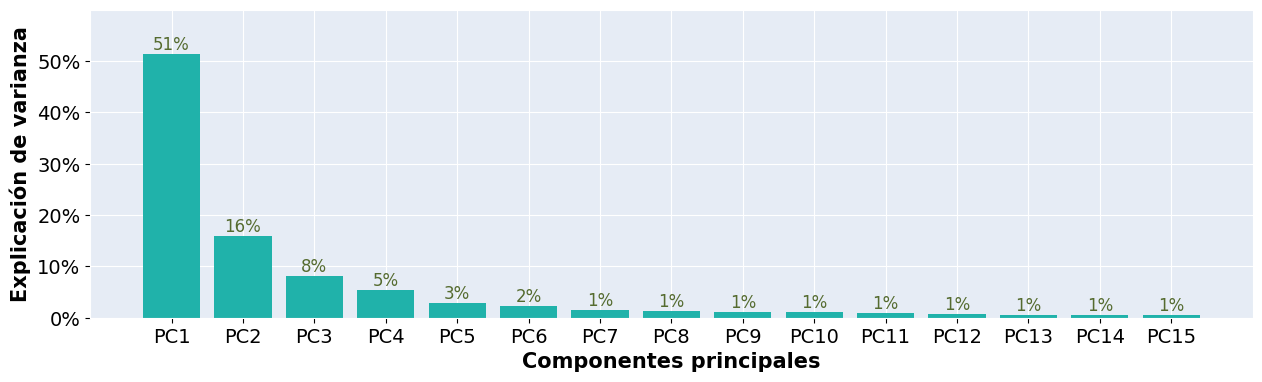

In [9]:
fig, ax = plt.subplots(figsize=(15,4))
bar = ax.bar([f'PC{i+1}' for i in range(15)], model.explained_variance_ratio_[:15], color='lightseagreen');
ax.bar_label(bar, color='darkolivegreen', fontsize=12, fmt='{:.0%}');
ax.set_ylim(0,0.6)
ax.set_xlabel('Componentes principales', fontdict=dict(size=15, weight='bold'))
ax.set_ylabel('Explicación de varianza', fontdict=dict(size=15, weight='bold'))
ax.set_yticks(np.linspace(0,0.5,6))
ax.set_yticklabels([f'{i}%' for i in range(0,60,10)]);
ax.tick_params(axis='both', labelsize=14)
fig.savefig('Images/explained_variance_ratio_pca.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/explained_variance_ratio_pca.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

,Date,Virus,State,Description,PC1,PC2,Mean_Dist,Errors,Codons
9711,2021-07-12,EPI_ISL_3055561,Puebla,PUE-LABOPAT-92_21416,3.482671,0.060937,3.484531,14,9508
9138,2021-07-07,EPI_ISL_3055556,Puebla,PUE-LABOPAT-71_26796,3.339802,0.366226,3.361234,4,9896
9433,2021-07-09,EPI_ISL_3055553,Puebla,PUE-LABOPAT-88_27202,2.950953,0.258439,2.963862,4,9896
...,...,...,...,...,...,...,...,...,...
37769,2022-01-06,EPI_ISL_9749698,Tabasco,TAB_InDRE_FB2531_E27713599244_S11088,2.235188,0.213639,2.247772,37,9852
33251,2021-12-21,EPI_ISL_8184728,Puebla,PUE-VZ21-87470-LABOPAT,2.202708,0.228071,2.216957,4,9808
11606,2021-07-23,EPI_ISL_3459980,Queretaro,QUE-InDRE_FB23899_S5429,2.114993,0.270725,2.134961,80,9822


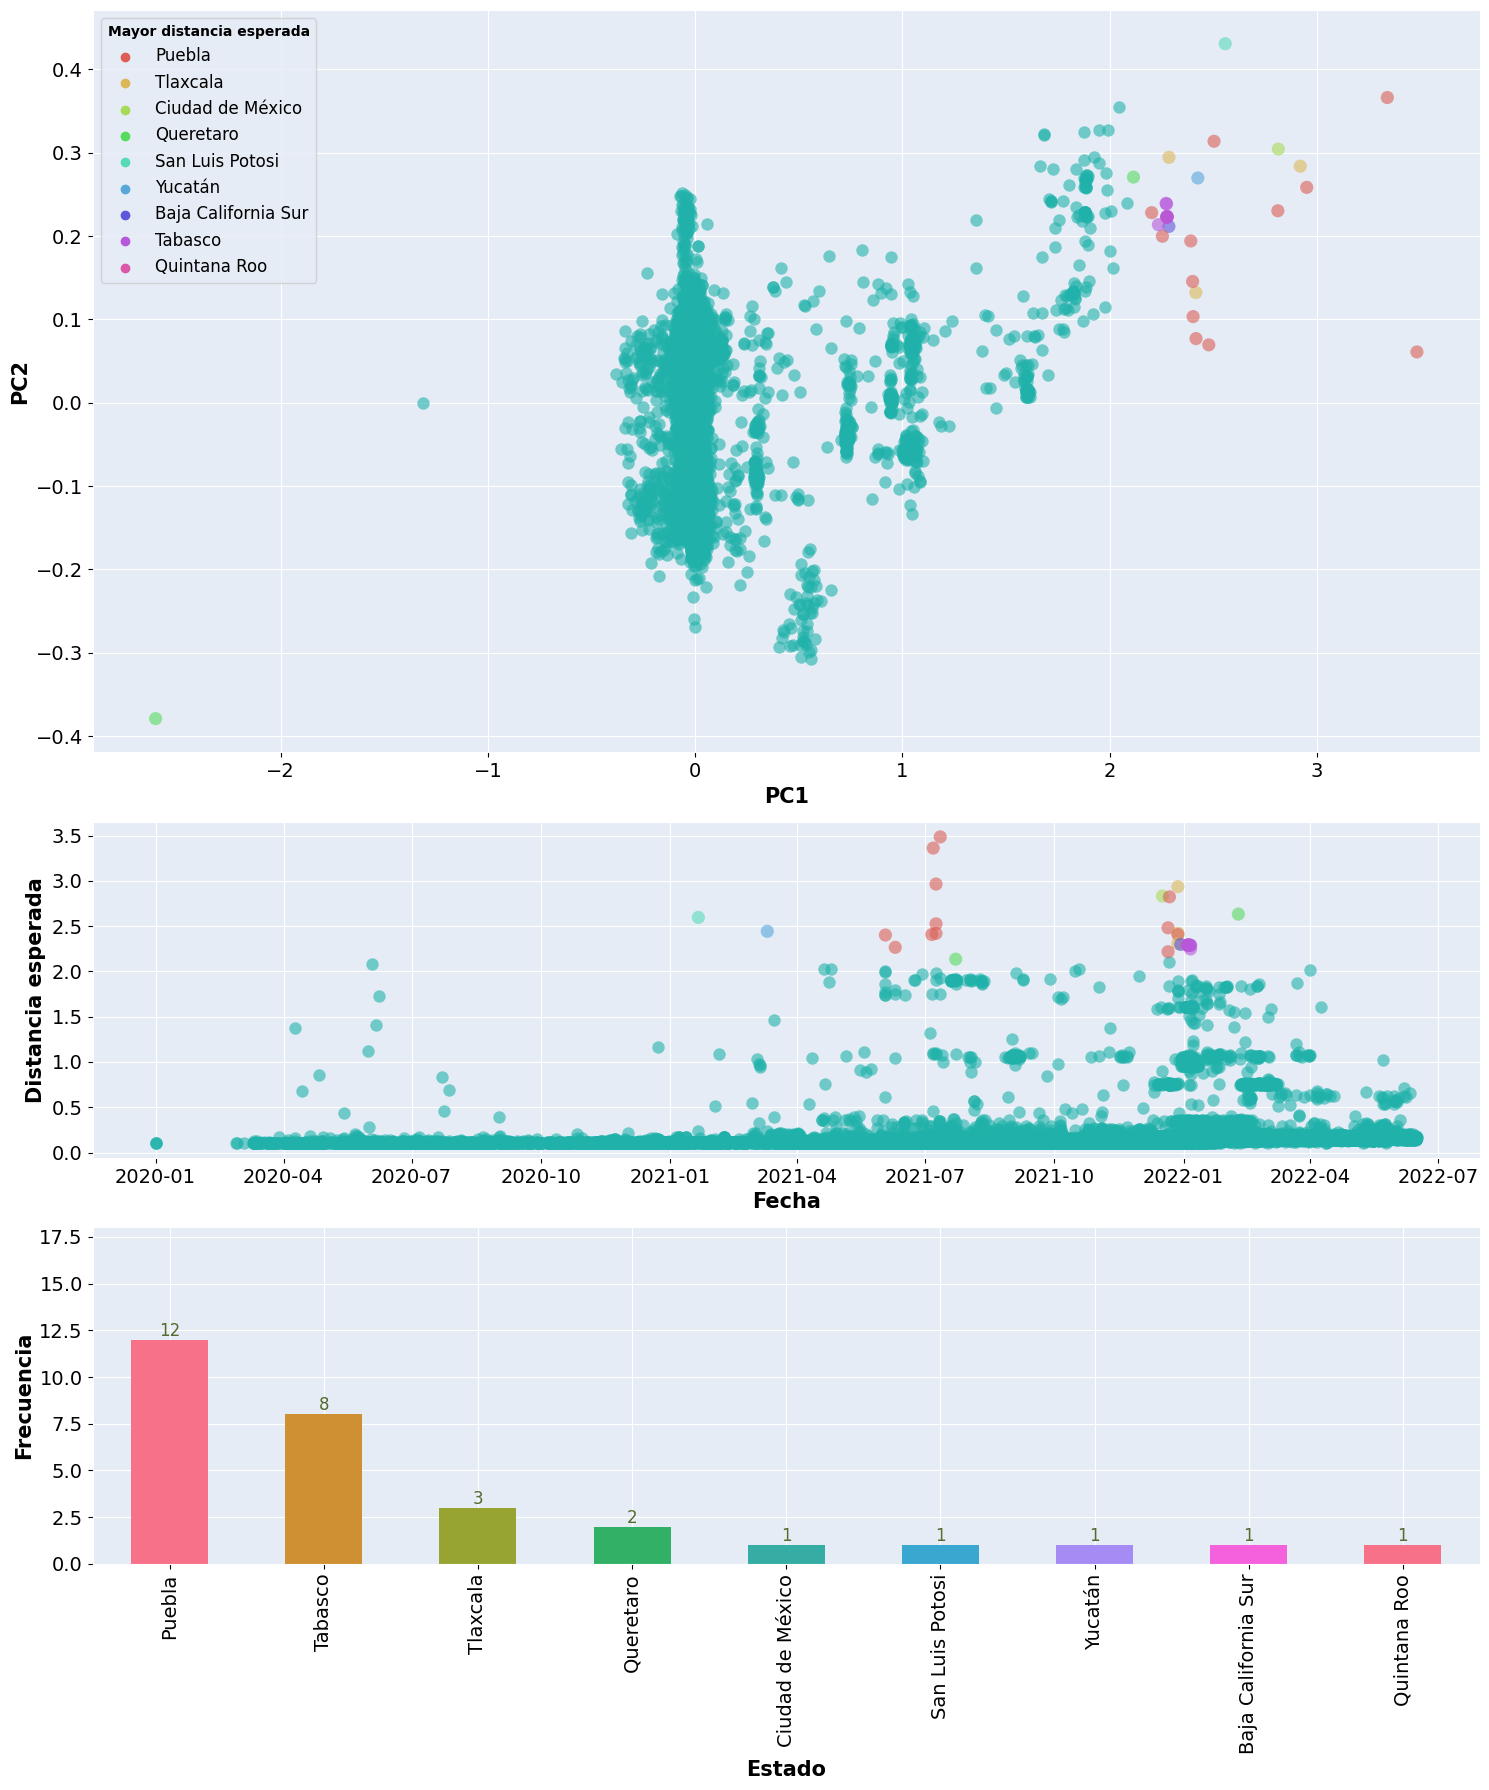

In [10]:
top = 30
largest_dist = codon_usage_pca.nlargest(top,'Mean_Dist')
data = codon_usage_pca.query('Virus not in @largest_dist.Virus')

fig, axes = plt.subplot_mosaic(mosaic="A;A;A;A;B;B;C;C", figsize=(15,18), tight_layout=True)
# Se crea la grafica de dispersion con los primeros dos componentes
sns.scatterplot(data=data, x='PC1', y='PC2', color='lightseagreen', ax=axes['A'], alpha=0.6, s=80, linewidth=0);

# Se crea la grafica de dispersion con las instancias de mayor distancia esperada
sns.scatterplot(data=largest_dist, x='PC1', y='PC2', hue='State', palette='hls', ax=axes['A'], alpha=0.6, s=90, linewidth=0);

axes['A'].legend(title='Mayor distancia esperada', title_fontproperties=dict(weight='bold'), fontsize=12, loc='upper left');
axes['A'].tick_params(axis='both', labelsize=14)
axes['A'].set_xlabel('PC1', fontdict=dict(size=15, weight='bold'))
axes['A'].set_ylabel('PC2', fontdict=dict(size=15, weight='bold'))

# Se crea la grafica de dispersion con los primeros dos componentes
sns.scatterplot(data=data, x='Date', y='Mean_Dist', color='lightseagreen', ax=axes['B'], alpha=0.6, s=80, linewidth=0);

# Se crea la grafica de dispersion con las instancias de mayor distancia esperada
sns.scatterplot(data=largest_dist, x='Date', y='Mean_Dist', hue='State', palette='hls', ax=axes['B'], alpha=0.6, s=90, linewidth=0, legend=False);

#axes['B'].legend(title='Mayor distancia esperada', title_fontproperties=dict(weight='bold'), fontsize=12, loc='upper left');
axes['B'].tick_params(axis='both', labelsize=14)
axes['B'].set_xlabel('Fecha', fontdict=dict(size=15, weight='bold'))
axes['B'].set_ylabel('Distancia esperada', fontdict=dict(size=15, weight='bold'))


# Se muestran como grafica de barras los top 30 estados con las instancias de mayor distancia esperada
bar = (largest_dist['State']
       .value_counts()
       .plot.bar(color=['#f77189', '#ce9032', '#97a431', '#32b166', '#36ada4', '#39a7d0', '#a48cf4', '#f561dd'], 
                 ax=axes['C']))
axes['C'].bar_label(bar.containers[0], color='darkolivegreen', fontsize=12);
axes['C'].set_ylim(0,18)
axes['C'].tick_params(axis='both', labelsize=14)
axes['C'].set_xlabel('Estado', fontdict=dict(size=15, weight='bold'))
axes['C'].set_ylabel('Frecuencia', fontdict=dict(size=15, weight='bold'))

display(largest_dist)
# Se guarda la figura
fig.savefig('Images/codon_usage_PCA.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/codon_usage_PCA.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

---

## ➤ Reducción de la dimensionalidad (Isomap)

Se reduce la dimensionalidad del conjunto de datos utilizado el método de Isomap. Donde la aplicación del método se realiza en el script ```ISOMAP.py```, y debido a la catidad de recursos necesarios solo se utilizaron el 80% de los datos (obtenidos por estado).

In [11]:
codon_usage_isomap = pd.read_csv('Archivos/codon_usage_isomap_078.csv', parse_dates=['Date'])
codon_usage_isomap

,Date,Virus,State,Description,1,2,Mean_Dist,Errors,Codons
0,2021-10-21,EPI_ISL_5846244,Oaxaca,OAX-INMEGEN-33-254,0.010186,0.006455,0.016669,195,9701
1,2021-04-20,EPI_ISL_2402190,Oaxaca,OAX_LANGEBIO_IMSS_0779,-0.003389,-0.006899,0.011918,94,9800
2,2021-09-07,EPI_ISL_4232414,Oaxaca,OAX-INMEGEN-27-231,-0.001729,0.014643,0.018234,765,9131
...,...,...,...,...,...,...,...,...,...
40028,2022-01-27,EPI_ISL_13560292,Desconocido,un-UGA_HRAEI_SSA_0309,-0.006975,0.003218,0.011734,3,9884
40029,2021-08-18,EPI_ISL_7813058,Desconocido,MEX-CABANA-MX-UGA-IMSS_ITV_UBA_UCR_UdA_UPC-3735,0.002980,-0.005230,0.010368,1,9895
40030,2021-08-04,EPI_ISL_7813048,Desconocido,MEX-CABANA-MX-UGA-IMSS_ITV_UBA_UCR_UdA_UPC-3702,0.003044,-0.010827,0.014403,2,9877


,Date,Virus,State,Description,1,2,Mean_Dist,Errors,Codons
15651,2021-07-09,EPI_ISL_3055553,Puebla,PUE-LABOPAT-88_27202,0.261153,0.021654,0.262284,4,9896
15498,2021-07-09,EPI_ISL_3055552,Puebla,PUE-LABOPAT-91_27256,0.223368,0.129848,0.258609,5,9895
16081,2021-07-06,EPI_ISL_3055554,Puebla,PUE-LABOPAT-70_26696,0.221955,0.127899,0.256411,4,9896
...,...,...,...,...,...,...,...,...,...
13911,2022-02-06,EPI_ISL_10052195,Ciudad de México,CMX-INMEGEN-58-264,0.132262,0.077194,0.153628,38,9850
16114,2022-01-07,EPI_ISL_8670505,Puebla,PUE-SE22-0002-LABOPAT,0.133104,0.059049,0.146114,5,9857
15575,2022-01-09,EPI_ISL_8672560,Puebla,PUE-VE22-5440-LABOPAT,0.124292,0.071076,0.143710,4,9872


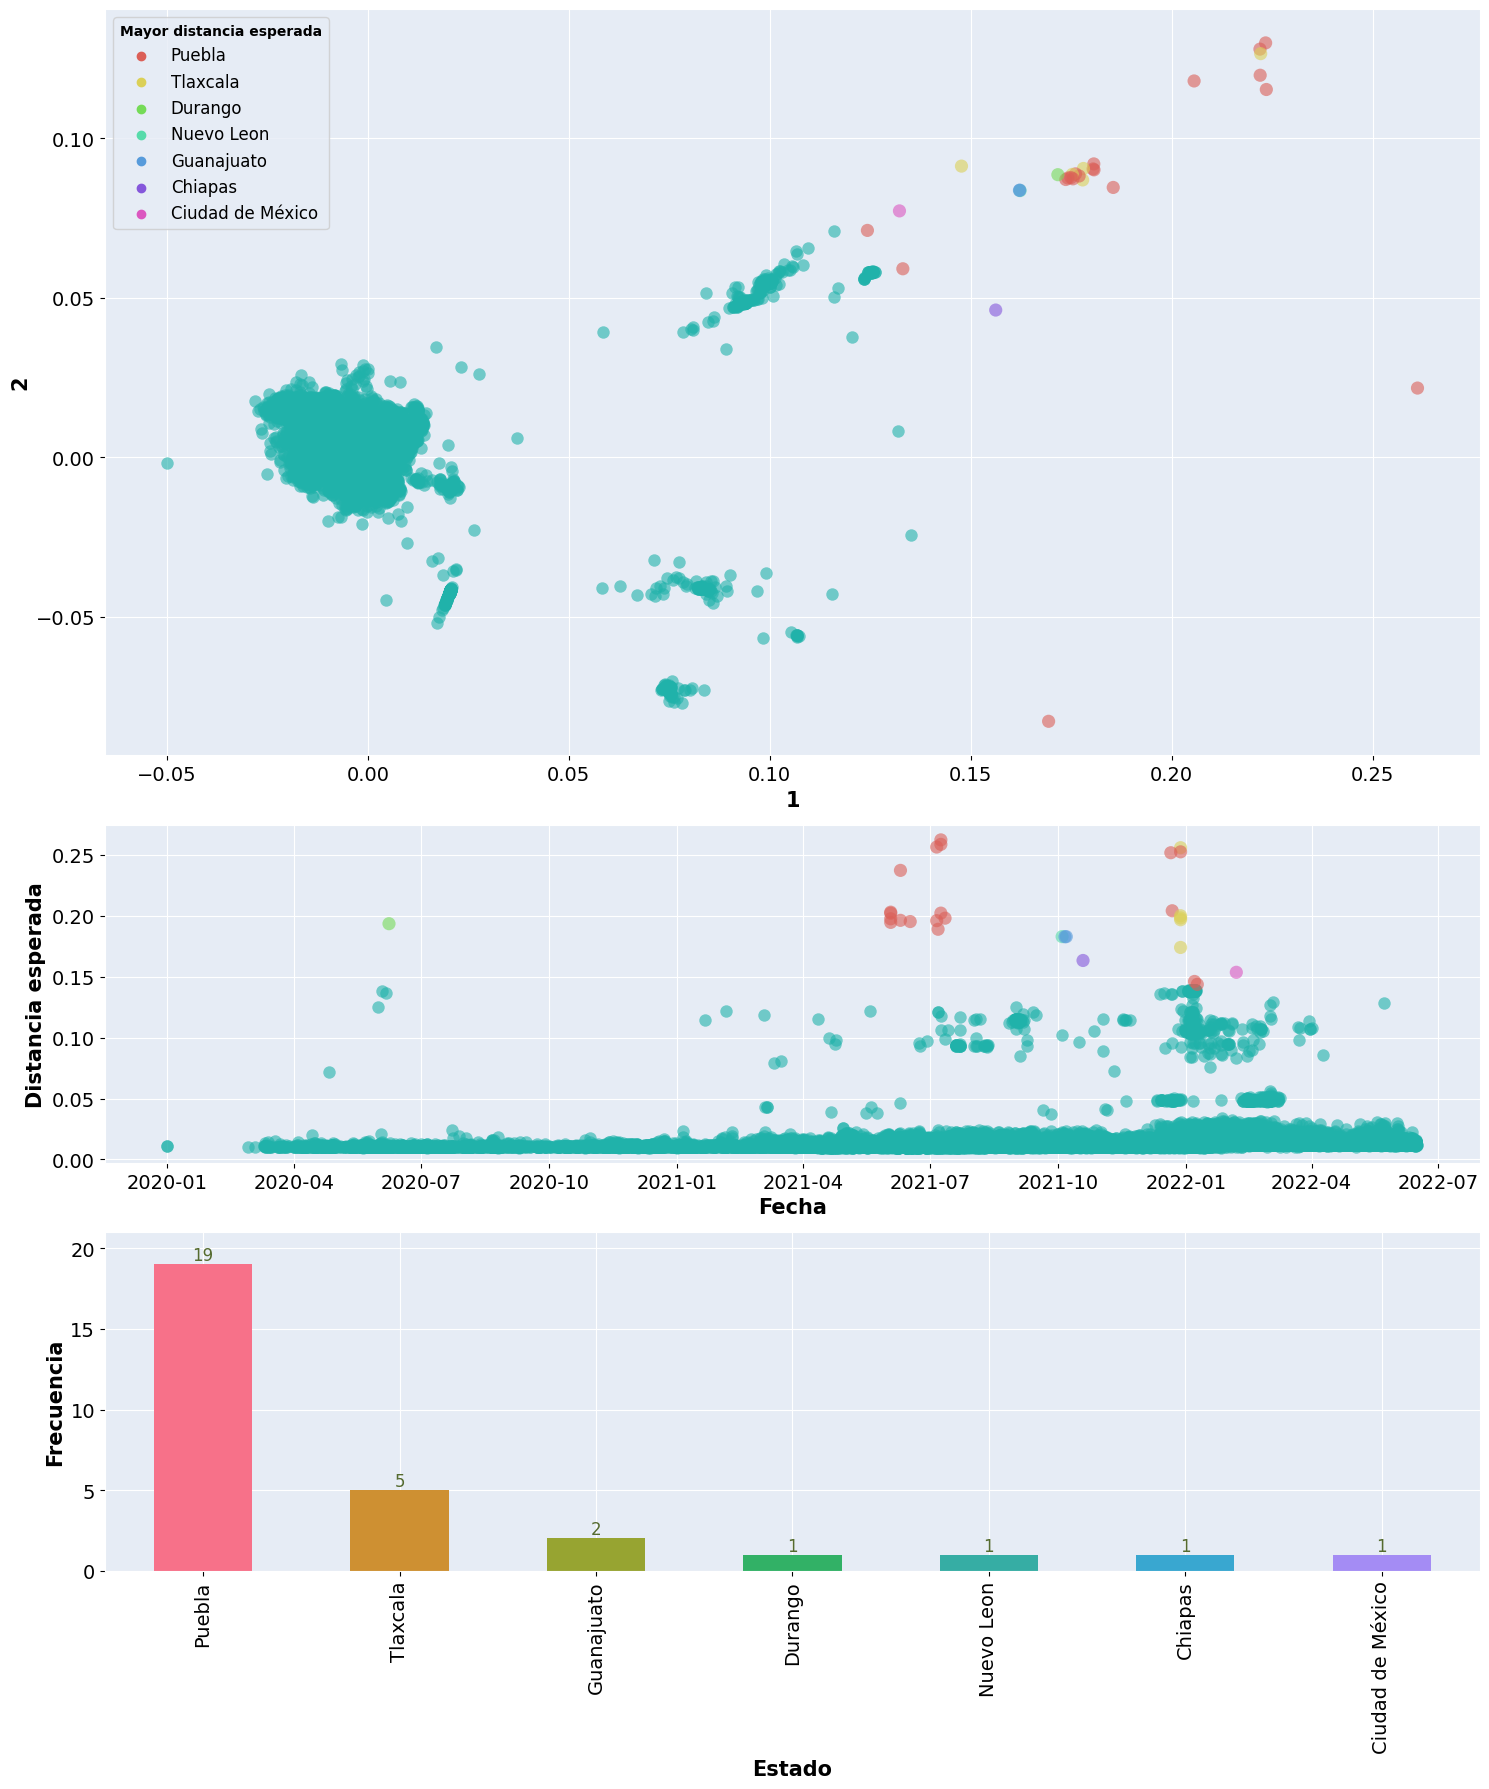

In [12]:
top = 30
largest_dist = codon_usage_isomap.nlargest(top,'Mean_Dist')
data = codon_usage_isomap.query('Virus not in @largest_dist.Virus')

fig, axes = plt.subplot_mosaic(mosaic="A;A;A;A;B;B;C;C", figsize=(15,18), tight_layout=True)
# Se crea la grafica de dispersion con los primeros dos componentes
sns.scatterplot(data=data, x='1', y='2', color='lightseagreen', ax=axes['A'], alpha=0.6, s=80, linewidth=0);

# Se crea la grafica de dispersion con las instancias de mayor distancia esperada
sns.scatterplot(data=largest_dist, x='1', y='2', hue='State', palette='hls', ax=axes['A'], alpha=0.6, s=90, linewidth=0);

axes['A'].legend(title='Mayor distancia esperada', title_fontproperties=dict(weight='bold'), fontsize=12, loc='upper left');
axes['A'].tick_params(axis='both', labelsize=14)
axes['A'].set_xlabel('1', fontdict=dict(size=15, weight='bold'))
axes['A'].set_ylabel('2', fontdict=dict(size=15, weight='bold'))

# Se crea la grafica de dispersion con los primeros dos componentes
sns.scatterplot(data=data, x='Date', y='Mean_Dist', color='lightseagreen', ax=axes['B'], alpha=0.6, s=80, linewidth=0);

# Se crea la grafica de dispersion con las instancias de mayor distancia esperada
sns.scatterplot(data=largest_dist, x='Date', y='Mean_Dist', hue='State', palette='hls', ax=axes['B'], alpha=0.6, s=90, linewidth=0, legend=False);

#axes['B'].legend(title='Mayor distancia esperada', title_fontproperties=dict(weight='bold'), fontsize=12, loc='upper left');
axes['B'].tick_params(axis='both', labelsize=14)
axes['B'].set_xlabel('Fecha', fontdict=dict(size=15, weight='bold'))
axes['B'].set_ylabel('Distancia esperada', fontdict=dict(size=15, weight='bold'))


# Se muestran como grafica de barras los top 30 estados con las instancias de mayor distancia esperada
bar = (largest_dist['State']
       .value_counts()
       .plot.bar(color=['#f77189', '#ce9032', '#97a431', '#32b166', '#36ada4', '#39a7d0', '#a48cf4', '#f561dd'], 
                 ax=axes['C']))
axes['C'].bar_label(bar.containers[0], color='darkolivegreen', fontsize=12);
axes['C'].set_ylim(0,21)
axes['C'].tick_params(axis='both', labelsize=14)
axes['C'].set_xlabel('Estado', fontdict=dict(size=15, weight='bold'))
axes['C'].set_ylabel('Frecuencia', fontdict=dict(size=15, weight='bold'))

display(largest_dist)
# Se guarda la figura
fig.savefig('Images/codon_usage_Isomap.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/codon_usage_Isomap.jpg', dpi=1000, bbox_inches='tight', facecolor='none')